In [56]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

if __name__ =='__main__':
    if not os.path.exists('./prepared_data/'):
        os.mkdir('./prepared_data/')
        
    df = pd.read_csv('./data/chessData.csv')
    
    train_df, test_df = train_test_split(df, test_size=0.2)

    train_df.to_csv('./prepared_data/train_chess_data.csv', encoding = 'utf-8', index=False)
    test_df.to_csv('./prepared_data/test_chess_data.csv', encoding = 'utf-8', index=False)
    


In [19]:
import pandas as pd 
import numpy as np
import chess
import torch


piece_list = ['pawn','knight','bishop','rook','queen','king']
piece_key = range(1,7)

piece_dict = dict(zip(piece_list, piece_key))

colour_dict = {'black':0, 'white':1}


def fen_translator(fen_string: str):
    
    board = chess.Board(fen_string)
    
    tensor = board_to_tensor(board = board)
    
    return tensor


def board_to_tensor(board: chess.Board) -> torch.Tensor:
    
    array_list = []
    
    for colour in colour_dict.values():
        for piece in piece_dict.values():
            piece_array = np.reshape(np.array(str(board.pieces(piece, colour)).replace(' ', ',').replace('.','0').replace('\n', ',').split(',')), (8,8)).astype(int)
            array_list.append(piece_array)
    
    
    array_list.append(create_ep_tensor(board))
    array_list.append(create_castle_tensor(board))
    array_list.append(create_half_move_clock_draw_tensor(board))
    array_list.append(create_to_move_tensor(board))
    
    tensor = torch.tensor(np.array(array_list))
    
    return tensor


def create_ep_tensor(board: chess.Board) -> np.ndarray:
    """
    Expects a board object and returns an 8x8 array with 1 on any ep position. 
    """
    
    
    ep_tensor = np.zeros(64)
    
    if board.ep_square:
        ep = board.ep_square
        ep_tensor[ep] = 1
        
    ep_tensor = ep_tensor.reshape(8,8)[-1::-1]
    
    return ep_tensor


def create_castle_tensor(board: chess.Board) -> np.ndarray:
    """
    Expects a board object and returns a 8x8 array with 1s in the corners where the kings may castle
    
    """
    
    castle_tensor = np.zeros(64).reshape((8,8))
    
    castling_rights = board.castling_rights
    
    pos_dict = {63: (0,7),
                56: (0,0),
                7: (7,7),
                0: (7,0)}
    
    for pos_number, pos_coordinates in pos_dict.items():
        
        if castling_rights >= 2**pos_number:
            castling_rights -= 2**pos_number
            castle_tensor[pos_coordinates] = 1
        
    return castle_tensor


def create_half_move_clock_draw_tensor(board: chess.Board) -> np.ndarray:
    
    if board.halfmove_clock>=100:
        
        return np.ones(64).reshape((8,8))
    
    else:
        
        return np.zeros(64).reshape((8,8))
    
    
def create_to_move_tensor(board: chess.Board) -> np.ndarray:
    
    if board.turn:
        return np.hstack((np.zeros(32), np.ones(32))).reshape(8,8)
    
    else:
        return np.hstack((np.ones(32), np.zeros(32))).reshape(8,8)
    
    
def evaluation_mate_handler(df: pd.DataFrame) -> pd.DataFrame:
    
    df = (df
          .dropna()
          .assign(Evaluation = lambda df: (df['Evaluation']
                                            .mask(df['Evaluation']
                                                  .str.contains('#-'), '-20000')))
          .assign(Evaluation = lambda df: (df['Evaluation']
                                            .mask(df['Evaluation']
                                                  .str.contains('#+'), '20000')))
          .assign(Evaluation = lambda df: (df['Evaluation']
                                           .str.replace('\ufeff', '')
                                           .str.replace(r'\s', '', regex=True)
                                           .str.replace('+', '')
                                           .astype(int))
                 )
         )
    
    return df



In [9]:
chess_path = './data/chessData.csv'

df = pd.read_csv(chess_path)


In [73]:
hold_batch[1].abs().max()

tensor(20000)

In [78]:
def div_max(tensor: torch.Tensor) -> torch.Tensor:
    
    tensor = tensor.to(torch.float32)
    
    tensor /= tensor.abs().max()
    
    return tensor

In [81]:
duck = '20000'

'-'+duck

'-20000'

In [ ]:
transforms.

In [80]:
div_max(hold_batch[1].to(torch.float32)).dtype

torch.float32

In [10]:
df = df.pipe(evaluation_mate_handler)

/tmp/ipykernel_79883/471159207.py:118: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('+', '')


<AxesSubplot:>

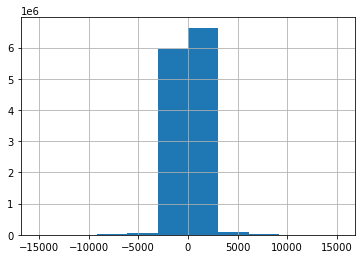

In [10]:
df.query('-1000000<Evaluation<1000000')['Evaluation'].hist()

<AxesSubplot:>

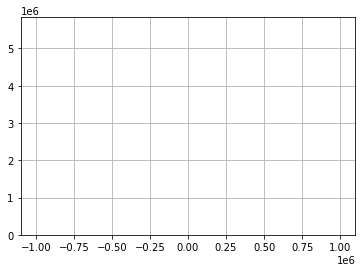

In [16]:
df['Evaluation'].hist(bins = 10000)

## Building the Pytorch Data Loader

In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
class FENDataset(Dataset):

    def __init__(self, evaluation_file_path: str):
        self.evaluation_file_path = evaluation_file_path
        self.evaluation_data = (pd.read_csv(self.evaluation_file_path)
                                .pipe(evaluation_mate_handler))
        
        
    def __len__(self):
        return len(self.evaluation_data)
    
    def __getitem__(self, idx):
        label = self.evaluation_data.loc[idx, 'Evaluation']
        tensor = fen_translator(self.evaluation_data.loc[idx, 'FEN'])
        
        return tensor, label

In [21]:
train_dataset = FENDataset( './prepared_data/train_chess_data.csv')
test_dataset = FENDataset( './prepared_data/test_chess_data.csv')

/tmp/ipykernel_282123/3894474985.py:118: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('+', '')
/tmp/ipykernel_282123/3894474985.py:118: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('+', '')


In [57]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [58]:
hold_batch = None
i = 0

for batch in test_dataloader:
    if i ==38: 
        hold_batch = batch
        break
    else:
        i+=1

In [62]:
loss = nn.MSELoss()

In [68]:
loss(net(hold_batch[0].to(torch.float32)), hold_batch[1])

tensor(8285698., grad_fn=<MseLossBackward0>)

In [69]:
loss(net(hold_batch[0].to(torch.float32)).reshape(-1), hold_batch[1].to(torch.float32))

tensor(8285697., grad_fn=<MseLossBackward0>)

In [70]:
net(hold_batch[0].to(torch.float32)).reshape(-1)

tensor([86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813,
        86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813,
        86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813,
        86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813,
        86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813,
        86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813,
        86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813,
        86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813, 86.8813],
       grad_fn=<ReshapeAliasBackward0>)

In [71]:
hold_batch[1]

tensor([ -5814, -20000,    178,    983,    -50,      0,    229,    119,      0,
            32,    376,    316,   -885,     72,   -138,     26,    -94,     71,
             0,   -165,     59,    324,     13,     21,    279,     16,   -110,
            13,   -530,    -84,    102,    109,     52,  -6923,   -903,     21,
          -281,     53,    237,    200,      0,    -52,   -243,     83,    -56,
            57,   -132,    123,      0,    174,     53,    667,   -118,  -6047,
          -272,     70,   -162,     59,   -615,    111,     97,    -84,    -92,
           292])

In [47]:
net(hold_batch[0].to(torch.float32))

tensor([[86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.8813],
        [86.

In [ ]:
hold

In [1]:
import logging

In [2]:
fmtstr = "%(asctime)s: (%(filename)s): %(levelname)s: %(funcName)s Line: %(lineno)d - %(message)s"
datestr = "%Y-%m-%d %H:%M:%S"

In [3]:
logging.basicConfig(
        filename="custom_log_output.log",
        level=logging.DEBUG,
        filemode="w",
        format=fmtstr,
        datefmt=datestr,
  )

In [4]:
logging.info('this is a log')

In [4]:
print(f'{0.448298382392939283839283:.6f}')

0.448298


In [5]:
import numpy as np

In [7]:
a= np.array([2.546,3.489,7.4869,11.4698])
b= np.array([2.1546,3.4489,7.74869,11.54698])

np.sum((a-b)**2)

0.22929272649999977

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from data_load_utils import FENDataset
from torchvision import transforms
import argparse
from torch.utils.data import DataLoader
import logging
import sys
import os
from torch.optim import AdamW
import numpy as np


In [10]:
class Model(nn.Module):
    def __init__(self, number_of_convolutions, number_of_filters): 
        super().__init__() 
        self.number_of_convolutions = number_of_convolutions
        self.number_of_filters = number_of_filters
        
        self.conv1 = nn.Conv2d(16, number_of_filters, kernel_size=3, stride = 1, padding = 'same') # Input Channels, Number of Kernels, Kernel Size 
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = 1) # Kernel Size, Stride 
        
        self.residual_list = nn.ModuleList([nn.Conv2d(number_of_filters, number_of_filters, kernel_size=3, stride = 1, padding='same') for i in range(number_of_convolutions)])
        
        
        self.fc1 = nn.Linear(number_of_filters*(8+number_of_convolutions+1)**2, 1) 
    
    def forward(self, x): 
        
        x = self.pool(F.relu(self.conv1(x))) 
        
        for conv_layer in self.residual_list:
            x = self.pool(F.relu(conv_layer(x))) 
        
        x = torch.flatten(x, 0) 
        
        x = self.fc1(x)

        return x

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from data_load_utils import FENDataset
from torchvision import transforms
import argparse
from torch.utils.data import DataLoader
import logging
import sys
import os
from torch.optim import AdamW
import numpy as np

class Model(nn.Module):
    def __init__(self, number_of_convolutions, number_of_filters): 
        super().__init__() 
        self.number_of_convolutions = number_of_convolutions
        self.number_of_filters = number_of_filters
        
        self.conv1 = nn.Conv2d(16, number_of_filters, kernel_size=3, stride = 1, padding = 'same') # Input Channels, Number of Kernels, Kernel Size 
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = 1) # Kernel Size, Stride 
        
        self.residual_list = nn.ModuleList([nn.Conv2d(number_of_filters, number_of_filters, kernel_size=3, stride = 1, padding='same') for i in range(number_of_convolutions)])
        
        
        self.fc1 = nn.Linear(number_of_filters*(8+number_of_convolutions+1)**2, 1) 
    
    def forward(self, x): 
        
        x = self.pool(F.relu(self.conv1(x))) 
        
        for conv_layer in self.residual_list:
            x = self.pool(F.relu(conv_layer(x))) 
        
        x = torch.flatten(x, 1)#1 because passing batch? 
        
        x = self.fc1(x)

        return x
    

In [19]:
net = Model(number_of_convolutions=5, number_of_filters=10)

In [20]:
net.load_state_dict(torch.load('models/chess_nc_5_nf_10_e_2_bs_64_lr_0.001.pth'))

<All keys matched successfully>

In [11]:
df

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...,6
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...,84
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...,0
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...,115


In [56]:
frame = fen_translator(df.loc[0,'FEN'])

NameError: name 'df' is not defined

In [25]:
torch.tensor(frame)

/tmp/ipykernel_79883/2816279505.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(frame)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [28]:
frame

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [27]:

net(torch.tensor(frame).to(torch.float32))

/tmp/ipykernel_79883/2085428302.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  net(torch.tensor(frame).to(torch.float32))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x196 and 1960x1)

In [23]:
net(frame.to(torch.float32))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x196 and 1960x1)

In [70]:
from torch import nn

class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        print(identity.shape)

        out = self.conv1(x)
        print(out.shape)
        out = self.bn1(out)
        print(out.shape)
        out = self.relu(out)
        print(out.shape)
        out = self.conv2(out)
        print(out.shape)
        out = self.bn2(out)
        print(out.shape)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)


        return out

In [71]:
class ResnetModel(nn.Module):
    def __init__(self, number_of_convolutions, number_of_filters): 
        super().__init__() 
        self.number_of_convolutions = number_of_convolutions
        self.number_of_filters = number_of_filters
        
        self.basicblock =  BasicBlock(16, number_of_filters)
        
        
        self.block_list = nn.ModuleList([BasicBlock(number_of_filters, number_of_filters) for i in range(number_of_convolutions)])
        
        
        self.fc1 = nn.Linear(16*8*8, 1) 
    
    def forward(self, x): 
        
        x = self.basicblock(x)
        print(x.shape)
        
        for block_layer in self.block_list:
            x = block_layer(x)
        
        x = torch.flatten(x, 1)#1 because passing batch? 
        
        x = self.fc1(x)

        return x
    

In [4]:
import torchsummary

In [72]:
block = BasicBlock(16,16).to('cuda:0')

In [75]:
resnet_model = ResnetModel(5,16).to('cuda:0')

In [36]:
16*8*8

1024

In [26]:
hold_batch[0].shape

torch.Size([64, 16, 8, 8])

In [52]:
torchsummary.summary(block, input_size=(16, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 8, 8]           2,304
       BatchNorm2d-2             [-1, 16, 8, 8]              32
              ReLU-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 16, 8, 8]           2,304
       BatchNorm2d-5             [-1, 16, 8, 8]              32
              ReLU-6             [-1, 16, 8, 8]               0
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.02
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [77]:
torchsummary.summary(resnet_model, input_size=(16, 8, 8))


torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
torch.Size([2, 16, 8, 8])
--------------------------------------

In [76]:
resnet_model(hold_batch[0].to(torch.float).to('cuda:0'))

torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])
torch.Size([64, 16, 8, 8])


tensor([[ 0.7736],
        [ 1.0469],
        [ 1.8279],
        [ 2.0453],
        [ 0.4074],
        [ 1.2706],
        [ 0.7688],
        [ 0.8457],
        [ 1.5446],
        [ 3.0530],
        [ 1.2010],
        [ 1.2852],
        [ 0.6718],
        [ 1.4506],
        [ 0.9064],
        [ 0.7543],
        [ 1.9375],
        [ 1.8682],
        [ 0.1956],
        [ 0.0975],
        [-0.3941],
        [-0.2912],
        [ 1.8353],
        [ 1.5088],
        [ 1.1772],
        [-1.4295],
        [ 0.5783],
        [ 0.7171],
        [ 0.2927],
        [ 1.7166],
        [ 1.7888],
        [ 1.4183],
        [-0.1855],
        [ 1.7660],
        [ 0.7692],
        [ 1.1087],
        [ 2.3195],
        [-0.1153],
        [ 1.4937],
        [ 1.8711],
        [ 0.7237],
        [ 0.4986],
        [ 0.7086],
        [ 1.5196],
        [ 1.2619],
        [ 1.2157],
        [ 1.8182],
        [ 1.4682],
        [ 0.8748],
        [ 1.5197],
        [ 1.7775],
        [ 0.8799],
        [ 0.